## Import required modules

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

## Data Loading and Visualization

In [ ]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
X_test.shape

(10000, 28, 28)

In [ ]:
y_test.shape

(10000,)

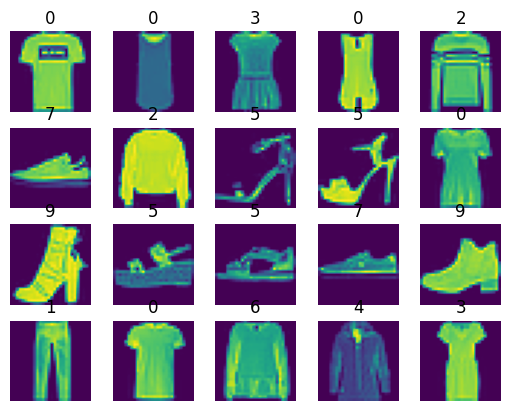

In [ ]:
for img in range(1,20+1):
  plt.subplot(4,5,img)
  plt.imshow(X_train[img])
  plt.title(y_train[img])
  plt.axis("off")

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

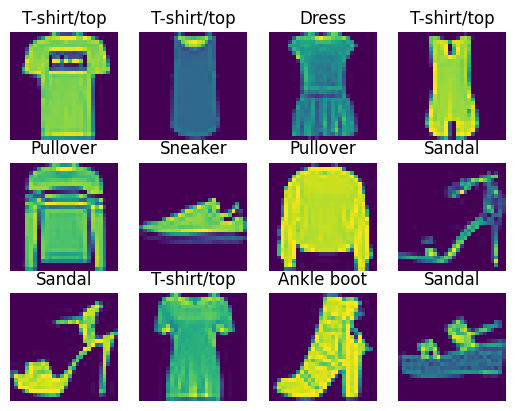

In [ ]:
for img in range(1,12+1):
  plt.subplot(3,4,img)
  plt.imshow(X_train[img])
  plt.title(class_names[y_train[img]])
  plt.axis("off")

## Data Preprocessing- Normalization

In [ ]:
train_images = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

In [ ]:
train_images = (train_images - 127.5) / 127.5

## Build Generator model

### Fake data points using Latent dimensions vector

In [ ]:
LATENT_DIM = 100
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
CHANNELS = 1 #channes will be three =3 if tiis RGB image

In [ ]:
def build_generator():
  model = Sequential()
  model.add(layers.Dense(7 * 7 * 256, input_dim=LATENT_DIM))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  model.add(layers.Reshape((7, 7, 256)))

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
  model.add(layers.BatchNormalization())
  model.add((layers.ReLU()))

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
  model.add(layers.BatchNormalization())
  model.add((layers.ReLU()))

  model.add(layers.Conv2D(CHANNELS, (5, 5), padding="same", activation="tanh"))
  return model

In [ ]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1266944   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 128)       819328    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 128)       5

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


## Build Discriminator model

### This is used to classify whether it is fake or real

In [ ]:
def build_discriminator(width, height, depth, alpha=0.2):
    model = Sequential()
    input_shape = (height, width, depth)

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same",
        input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1, activation="sigmoid"))

    return model

In [ ]:
discriminator = build_discriminator(28, 28, 1)
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 batch_normalization_3 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 batch_normalization_4 (Bat  (None, 7, 7, 128)         512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)        

## Build DCGAN architecture

In [ ]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    @tf.function
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        # Step 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0)
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        fake_images = self.generator(noise, training=True)

        pred_real = self.discriminator(real_images, training=True)
        pred_fake = self.discriminator(fake_images, training=True)

        d_loss_real = self.loss_fn(tf.ones_like(pred_real), pred_real)
        d_loss_fake = self.loss_fn(tf.zeros_like(pred_fake), pred_fake)
        d_loss = (d_loss_real + d_loss_fake) / 2

        grads = tf.gradients(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Step 2. Train the generator (do not update weights of the discriminator)
        pred_fake = self.discriminator(fake_images, training=True)
        g_loss = self.loss_fn(tf.ones_like(pred_fake), pred_fake)

        grads = tf.gradients(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}


## Callbacks

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.seed = tf.random.normal([16, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(5, 5))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i])
            plt.imshow(img, cmap='gray')
            plt.axis('off')
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

## Compile.Fit.Train your GAN

In [ ]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=100)

In [ ]:
LR = 0.0002

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=LR, beta_1 = 0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

Epoch 1/10
   4/1875 [..............................] - ETA: 42s - d_loss: 0.7300 - g_loss: 1.1621    

1874/1875 [============================>.] - ETA: 0s - d_loss: 0.0548 - g_loss: 5.5846

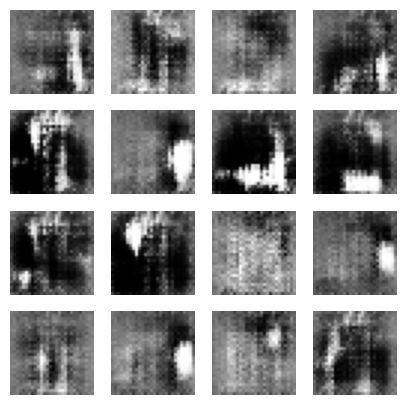

1875/1875 [==============================] - 42s 14ms/step - d_loss: 0.0548 - g_loss: 5.5841
Epoch 2/10
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.0023 - g_loss: 7.4160

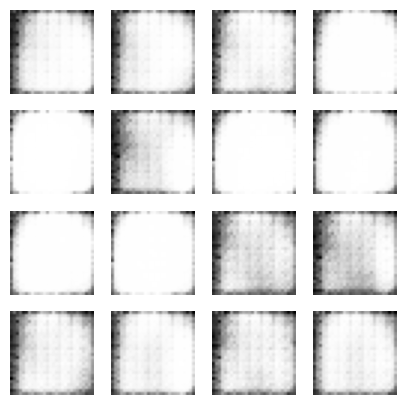

1875/1875 [==============================] - 27s 14ms/step - d_loss: 0.0023 - g_loss: 7.4171
Epoch 3/10
1336/1875 [====================>.........] - ETA: 7s - d_loss: 0.0150 - g_loss: 8.5190

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-d13b9f04d8ce>", line 2, in <cell line: 2>
    dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=100)])
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1783, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 831, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/p


KeyboardInterrupt



In [ ]:
NUM_EPOCHS = 10
dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=100)])

## Evaluation

In [ ]:
num_images_to_generate = 16  # Adjust as needed
random_noise = tf.random.normal(shape=(num_images_to_generate, LATENT_DIM))

generated_images = dcgan.generator(random_noise, training=False)

In [ ]:
generated_images.shape

TensorShape([16, 28, 28, 1])

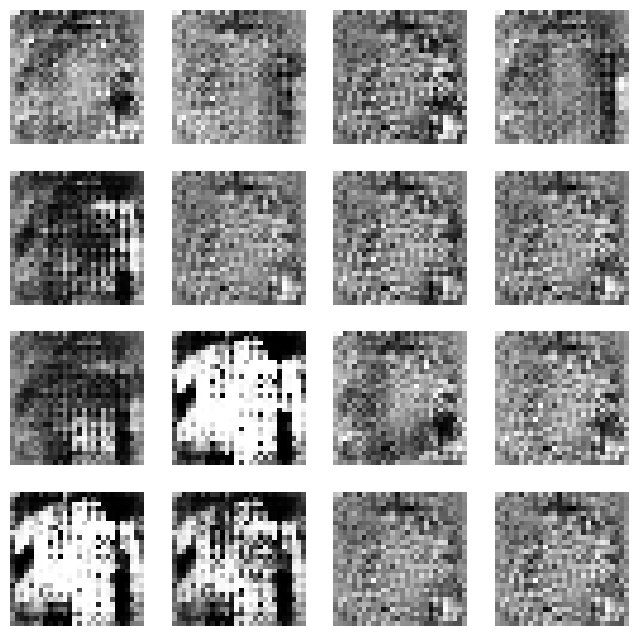

In [ ]:
plt.figure(figsize=(8,8))
for i in range(generated_images.shape[0]):
  plt.subplot(4,4,i+1)
  plt.imshow(generated_images[i],cmap="gray")
  plt.axis("off")

In [ ]:
import imageio
import time
from IPython.display import display, Image,clear_output

In [ ]:
num_frames = 30

In [ ]:
animation_noise = tf.random.normal(shape=(num_frames, LATENT_DIM))

In [ ]:
animation_noise.shape

TensorShape([30, 100])

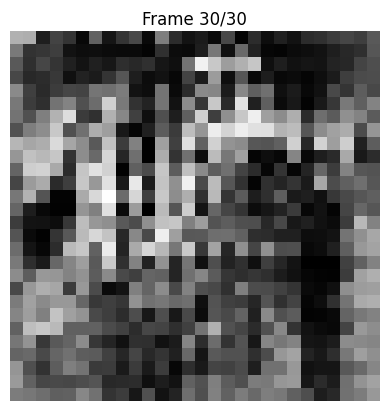

In [ ]:
for i in range(num_frames):
    clear_output(wait=True)

    generated_image = dcgan.generator(animation_noise[i:i+1], training=False).numpy()

    plt.imshow(np.squeeze(generated_image), cmap="gray")
    plt.title(f"Frame {i+1}/{num_frames}")
    plt.axis("off")
    plt.show()

    time.sleep(0.2)

## What's next?: Road to Generative AI

- GitHub Repo: [https://github.com/lucifertrj/road-to-genAI](https://github.com/lucifertrj/road-to-genAI)
- Discord Community for discussions: [https://discord.com/invite/hEMqtDXCHA](https://discord.com/invite/hEMqtDXCHA)